# Machine Learning to Maximise Profit
## Setup

In [1]:
from keras.layers import BatchNormalization, Dense, Input, Dropout
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.
K:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
K:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
K:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
K:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarn

In [2]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint

In [3]:
# Load in trained model
bst = pickle.load(open("../3. ML/bst.pickle.dat", "rb"))

In [4]:
df = pd.read_csv('../data/formatted_mens.csv',header=0,parse_dates=["Date"])
df.dropna(inplace=True)

categorical_cols = ['Tournament', 'Court', 'Surface', 'Round', 'A', 'B']
df = pd.get_dummies(df,columns=categorical_cols,drop_first=True)

dates = df.loc[:,['Date']]
d = xgb.DMatrix(df.drop(columns=['Date','y']), label=df['y'])
df['prediction'] = bst.predict(d)

In [5]:
cols_to_keep = ['Date','A_Max', 'B_Max','ranking_p','alpha_p','prediction','y']
df = df.loc[:,cols_to_keep]

In [6]:
split_time = pd.to_datetime('2018-01-01') # SAME SPLIT FROM ML EXPLORING
X_train = df.loc[df['Date']<split_time,['A_Max', 'B_Max','ranking_p','alpha_p','prediction']]
X_test = df.loc[df['Date']>=split_time,['A_Max', 'B_Max','ranking_p','alpha_p','prediction']]
y_train = df.loc[df['Date']<split_time,['y','A_Max', 'B_Max']]
y_test = df.loc[df['Date']>=split_time,['y','A_Max', 'B_Max']]

## Custom Loss Function

In [7]:
def odds_loss(y_true,y_pred):
    return_if_a_wins = y_pred[:,0]*y_true[:,1] - (1-y_pred[:,0])
    return_if_b_wins = (1-y_pred[:,0])*y_true[:,2] - y_pred[:,0]
    
    returns = y_true[:,0]*return_if_a_wins + (1-y_true[:,0])*return_if_b_wins
    return -K.mean(returns)

## Machine Learning

In [19]:
cols_to_keep = ['Date','A_Max', 'B_Max','ranking_p','alpha_p','prediction','y']
df = df.loc[:,cols_to_keep]
df = df.loc[df.Date>=split_time,:]

In [8]:
model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=odds_loss, optimizer='adam')

In [9]:
model.fit(X_train, y_train, epochs=50, batch_size=5)


Epoch 1/50
19401/19401 [==============================] - 8s 395us/step - loss: -0.6724
Epoch 2/50
19401/19401 [==============================] - 8s 404us/step - loss: -0.7208
Epoch 3/50
19401/19401 [==============================] - 8s 407us/step - loss: -0.7336
Epoch 4/50
19401/19401 [==============================] - 8s 410us/step - loss: -0.7533
Epoch 5/50
19401/19401 [==============================] - 8s 402us/step - loss: -0.7806
Epoch 6/50
19401/19401 [==============================] - 8s 405us/step - loss: -0.8241
Epoch 7/50
19401/19401 [==============================] - 8s 407us/step - loss: -0.8936
Epoch 8/50
19401/19401 [==============================] - 8s 400us/step - loss: -0.9437
Epoch 9/50
19401/19401 [==============================] - 7s 382us/step - loss: -0.9909
Epoch 10/50
19401/19401 [==============================] - 7s 342us/step - loss: -1.0159
Epoch 11/50
19401/19401 [==============================] - 8s 414us/step - loss: -1.0439
Epoch 12/50
19401/19401 [====

In [24]:
df['bet_amounts']

44664    1.490116e-07
44665    6.496906e-06
44666    9.983434e-01
44667    2.339780e-04
44668    9.634580e-01
             ...     
50582    4.768372e-07
50583    0.000000e+00
50584    5.106837e-03
50585    9.998233e-01
50586    9.854712e-01
Name: bet_amounts, Length: 5922, dtype: float32

In [22]:
df['bet_amounts'] = np.array(model.predict(X_test)[:,0])
r_if_a_wins = X_test['A_Max'] * df['bet_amounts'] - (1-df['bet_amounts'])
r_if_b_wins = X_test['B_Max'] * (1-df['bet_amounts']) - df['bet_amounts']
df['returns'] = np.where(y_test['y']==1,r_if_a_wins,r_if_b_wins)

In [ ]:
df['returns']

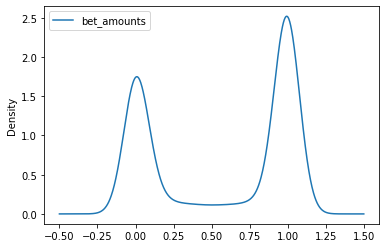

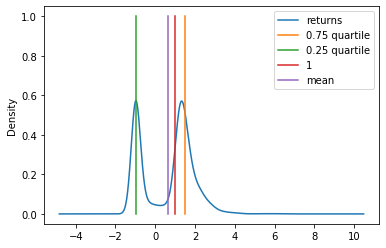

In [39]:
df.plot(y='bet_amounts',kind='kde')
df.plot(y='returns',kind='kde')
plt.plot([df['returns'].quantile(0.75)]*50,np.linspace(0,1),label='0.75 quartile')
plt.plot([df['returns'].quantile(0.25)]*50,np.linspace(0,1),label='0.25 quartile')
plt.plot([1]*50,np.linspace(0,1),label='1')
plt.plot([df['returns'].mean()]*50,np.linspace(0,1),label='mean')
plt.legend()